## Multi-Armed Bandits

In [113]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal as MN

%matplotlib inline

In [2]:
# random_state = np.random.RandomState(seed=81)

### Epsilon-greedy with sample-average action-value estimates

In [3]:
n_actions = 10
max_steps = 500
n_problems = 100

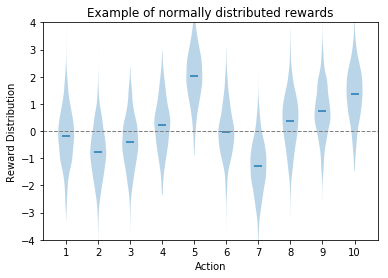

In [4]:
action_value_means = MN(np.zeros(n_actions), 1).rvs()
reward_distribution = MN(action_value_means, 1)

plt.violinplot(reward_distribution.rvs(size=1000), 
               showmeans=True, showextrema=False, points=100)
plt.axhline(linestyle='dashed', color='grey', linewidth=1)
plt.ylim(-4, 4)
plt.xticks(range(1, 11))
plt.xlabel('Action')
plt.ylabel('Reward Distribution')
plt.title('Example of normally distributed rewards')
plt.show()

In [5]:
def epsilon_greedy(epsilon, reward_function,
                   n_actions=10, max_steps=100):
    """Sample average action value estimates from epsilon-greedy actions."""
    Q = np.zeros(n_actions)
    N = np.zeros(n_actions)
    rewards = []
    actions = []
    
    for _ in range(max_steps):
        u = np.random.uniform(0, 1)
        if u < (1 - epsilon):
            # argmax with ties broken arbotrarily
            greedy_actions = np.flatnonzero(Q == np.max(Q))
            action = np.random.choice(greedy_actions)
        else:
            action = np.random.randint(n_actions)
        reward = reward_function(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        
        rewards.append(reward)
        actions.append(action)
        
    optimal_action = np.argmax(reward_function.distribution.mean)
    is_optimal = np.equal(actions, optimal_action)
    percent_optimal = np.cumsum(is_optimal) / np.arange(1, max_steps+1)
    
    return Q, percent_optimal, np.array(rewards)

In [6]:
class StationaryReward():
    def __init__(self, n_actions):
        self.initial_action_values = MN(np.zeros(n_actions), 1).rvs()
        self.distribution = MN(self.initial_action_values, 1)
        
    def __call__(self, action):
        return self.distribution.rvs()[action]

class NonStationaryReward():
    def __init__(self, n_actions):
        self.initial_action_values = MN(np.zeros(n_actions), 1).rvs()
        self.distribution = MN(self.initial_action_values, 1)
        self.step_dist = MN(np.zeros(n_actions), 0.01)
        
    def __call__(self, action):
        self.distribution = MN(self.distribution.mean + self.step_dist.rvs(), 1)
        return self.distribution.rvs()[action]

#### Stationary reward distribution

In [7]:
epsilons = (0, 0.01, 0.10)
rewards_stationary = np.zeros((3, n_problems, max_steps))
optimal_stationary = np.zeros((3, n_problems, max_steps))
for i, eps in enumerate(epsilons):
    for j in range(n_problems):
        stationary_reward = StationaryReward(n_actions)
        Q_st, optimal_stationary[i,j,:], rewards_stationary[i,j,:] = epsilon_greedy(
            eps, stationary_reward, max_steps=max_steps)
    print(i+1)

1
2
3


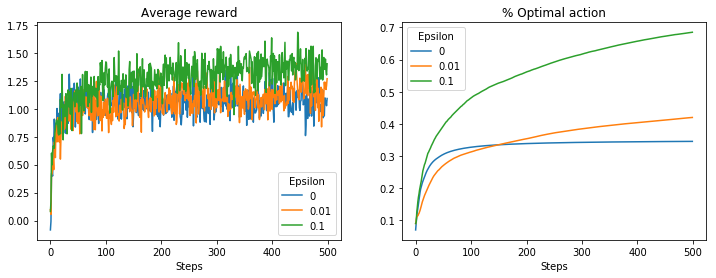

In [17]:
avg_reward = np.mean(rewards_stationary, axis=1)
avg_percent_optimal = np.mean(optimal_stationary, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for i in range(3):
    ax1.plot(range(max_steps), avg_reward[i], label=epsilons[i])
    ax2.plot(range(max_steps), avg_percent_optimal[i], label=epsilons[i])

for ax in (ax1, ax2):
    ax.set_xlabel('Steps')
    ax.legend(title='Epsilon')
ax1.set_title('Average reward')
ax2.set_title('% Optimal action')
plt.show()
print()

#### Nonstationary reward distribution

In [9]:
rewards_nonstationary = np.zeros((3, n_problems, max_steps))
optimal_nonstationary = np.zeros((3, n_problems, max_steps))
for i, eps in enumerate(epsilons):
    for j in range(n_problems):
        nonstationary_reward = NonStationaryReward(n_actions)
        Q_no, optimal_nonstationary[i,j,:], rewards_nonstationary[i,j,:] = epsilon_greedy(
            eps, nonstationary_reward, max_steps=max_steps)
    print(i+1)

1
2
3


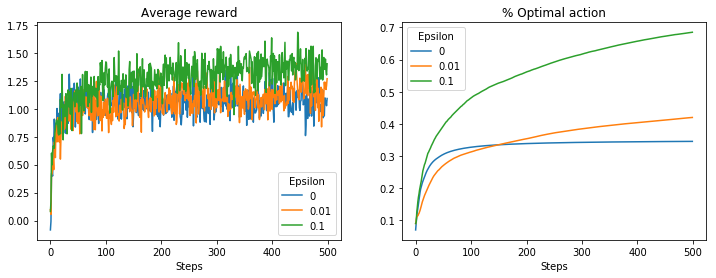

In [14]:
avg_reward = np.mean(rewards_stationary, axis=1)
avg_percent_optimal = np.mean(optimal_stationary, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for i in range(3):
    ax1.plot(range(max_steps), avg_reward[i], label=epsilons[i])
    ax2.plot(range(max_steps), avg_percent_optimal[i], label=epsilons[i])

for ax in (ax1, ax2):
    ax.set_xlabel('Steps')
    ax.legend(title='Epsilon')
ax1.set_title('Average reward')
ax2.set_title('% Optimal action')
plt.show()
print()

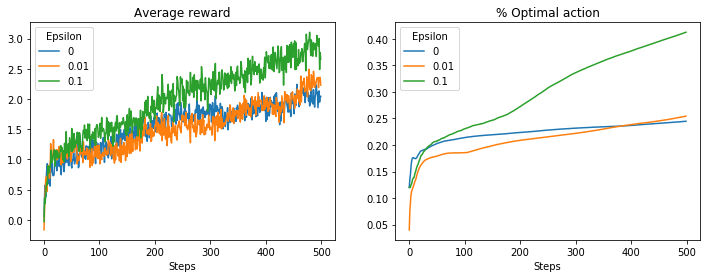

In [15]:
avg_reward = np.mean(rewards_nonstationary, axis=1)
avg_percent_optimal = np.mean(optimal_nonstationary, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for i in range(3):
    ax1.plot(range(max_steps), avg_reward[i], label=epsilons[i])
    ax2.plot(range(max_steps), avg_percent_optimal[i], label=epsilons[i])
    
for ax in (ax1, ax2):
    ax.set_xlabel('Steps')
    ax.legend(title='Epsilon')
ax1.set_title('Average reward')
ax2.set_title('% Optimal action')
plt.show()

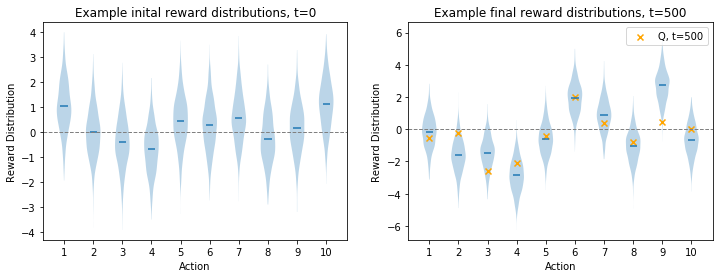

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.violinplot(MN(nonstationary_reward.initial_action_values, 1).rvs(size=1000), 
               showmeans=True, showextrema=False, points=100)
ax2.violinplot(nonstationary_reward.distribution.rvs(size=1000), 
               showmeans=True, showextrema=False, points=100)

for ax in (ax1, ax2):
    ax.axhline(linestyle='dashed', color='grey', linewidth=1)
    ax.set_xticks(range(1, 11))
    ax.set_xlabel('Action')
    ax.set_ylabel('Reward Distribution')
ax1.set_title('Example inital reward distributions, t=0')
ax2.set_title('Example final reward distributions, t={}'.format(max_steps))
ax2.scatter(range(1,11), Q_no, color='orange', marker='x',
            label='Q, t={}'.format(max_steps))
ax2.legend()
plt.show()

### Epsilon-greedy with exponential recency-weighted action-value estimates
Better for tracking a problem with nonstationary rewards

### Epsilon-greedy with optimistic initial values
Simple way to encourage exploration at the start (so only suitable for stationary problems).


### Upper-Confidence-Bound action selection
A way to include uncertainty of action-value estimate when selecting an action (but not obvious how to use for nonstationary problems and doesn't scale to large state space).

In [96]:
def upper_confidence_bound(reward_function, c=1,
                           n_actions=10, max_steps=100):
    """Action selection using sample average action value estimates plus confidence bound.
    
    Called "UCB1" in [Auer, Cesa-Bianchi and Fischer (2002)]
    (https://link.springer.com/article/10.1023/A:1013689704352)
    """
    Q = np.zeros(n_actions)
    N = np.zeros(n_actions)
    rewards = []
    actions = []
    
    for t in range(max_steps):
        if not np.all(N):  
            # if N(A) == 0, consider A a maximising actions
            greedy_actions = np.flatnonzero(N == 0)
        else: 
            ucb = Q + c*np.sqrt(np.log(t+1)/N)
            greedy_actions = np.flatnonzero(ucb == np.max(ucb))
        action = np.random.choice(greedy_actions)

        reward = reward_function(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        
        rewards.append(reward)
        actions.append(action)
        
    optimal_action = np.argmax(reward_function.distribution.mean)
    is_optimal = np.equal(actions, optimal_action)
    percent_optimal = np.cumsum(is_optimal) / np.arange(1, max_steps+1)
    
    return Q, percent_optimal, np.array(rewards)

In [97]:
conf_levels = (0.1, 1, 2)
rewards_stationary = np.zeros((3, n_problems, max_steps))
optimal_stationary = np.zeros((3, n_problems, max_steps))

for i, c in enumerate(conf_levels):
    for j in range(n_problems):
        stationary_reward = StationaryReward(n_actions)
        Q_st, optimal_stationary[i,j,:], rewards_stationary[i,j,:] = upper_confidence_bound(
            stationary_reward, c=c, max_steps=max_steps)
    print(i+1)

1
2
3


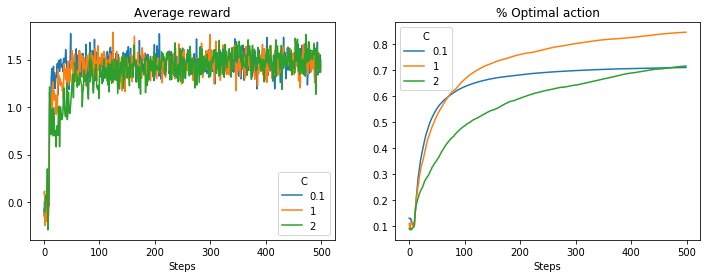

In [98]:
avg_reward = np.mean(rewards_stationary, axis=1)
avg_percent_optimal = np.mean(optimal_stationary, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for i in range(3):
    ax1.plot(range(max_steps), avg_reward[i], label=conf_levels[i])
    ax2.plot(range(max_steps), avg_percent_optimal[i], label=conf_levels[i])

for ax in (ax1, ax2):
    ax.set_xlabel('Steps')
    ax.legend(title='C')
ax1.set_title('Average reward')
ax2.set_title('% Optimal action')
plt.show()
print()

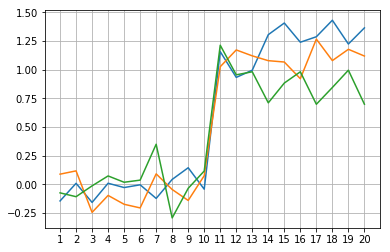

In [99]:
t = 20
plt.plot(range(1, t+1), avg_reward[:,:t].T)
plt.xticks(range(1, t+1))
plt.grid()
plt.show()

In [100]:
avg_reward_ucb = avg_reward
avg_percent_optimal_ucb = avg_percent_optimal

In [101]:
def epsilon_greedy_ucb(epsilon, reward_function, c=1,
                   n_actions=10, max_steps=100):
    """Sample average action value estimates from epsilon-greedy actions."""
    Q = np.zeros(n_actions)
    N = np.zeros(n_actions)
    rewards = []
    actions = []
    
    for t in range(max_steps):
        u = np.random.uniform(0, 1)
        if u < (1 - epsilon):
            if not np.all(N):  
                # if N(A) == 0, consider A a maximising actions
                greedy_actions = np.flatnonzero(N == 0)
            else: 
                ucb = Q + c*np.sqrt(np.log(t+1)/N)
                greedy_actions = np.flatnonzero(ucb == np.max(ucb))
            action = np.random.choice(greedy_actions)
        else:
            action = np.random.randint(n_actions)
        reward = reward_function(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        
        rewards.append(reward)
        actions.append(action)
        
    optimal_action = np.argmax(reward_function.distribution.mean)
    is_optimal = np.equal(actions, optimal_action)
    percent_optimal = np.cumsum(is_optimal) / np.arange(1, max_steps+1)
    
    return Q, percent_optimal, np.array(rewards)

1
2
3


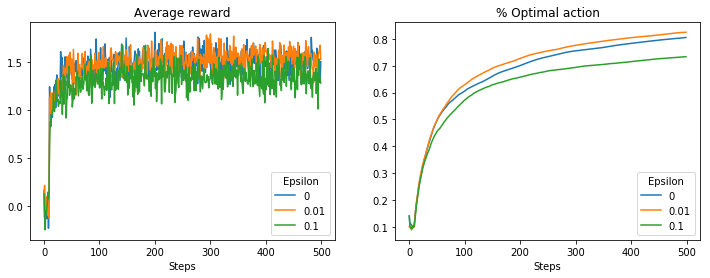

In [102]:
epsilons = (0, 0.01, 0.10)
rewards_stationary = np.zeros((3, n_problems, max_steps))
optimal_stationary = np.zeros((3, n_problems, max_steps))
for i, eps in enumerate(epsilons):
    for j in range(n_problems):
        stationary_reward = StationaryReward(n_actions)
        Q_st, optimal_stationary[i,j,:], rewards_stationary[i,j,:] = epsilon_greedy_ucb(
            eps, stationary_reward, max_steps=max_steps)
    print(i+1)

avg_reward = np.mean(rewards_stationary, axis=1)
avg_percent_optimal = np.mean(optimal_stationary, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for i in range(3):
    ax1.plot(range(max_steps), avg_reward[i], label=epsilons[i])
    ax2.plot(range(max_steps), avg_percent_optimal[i], label=epsilons[i])

for ax in (ax1, ax2):
    ax.set_xlabel('Steps')
    ax.legend(title='Epsilon')
ax1.set_title('Average reward')
ax2.set_title('% Optimal action')
plt.show()
print()

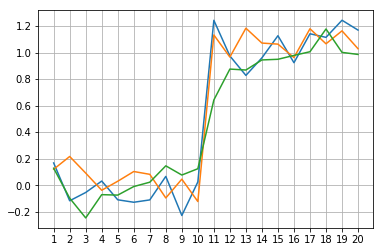

In [103]:
t = 20
plt.plot(range(1, t+1), avg_reward[:,:t].T)
plt.xticks(range(1, t+1))
plt.grid()
plt.show()

In [104]:
avg_reward_eps_ucb = np.mean(rewards_stationary, axis=1)
avg_percent_optimal_eps_ucb = np.mean(optimal_stationary, axis=1)

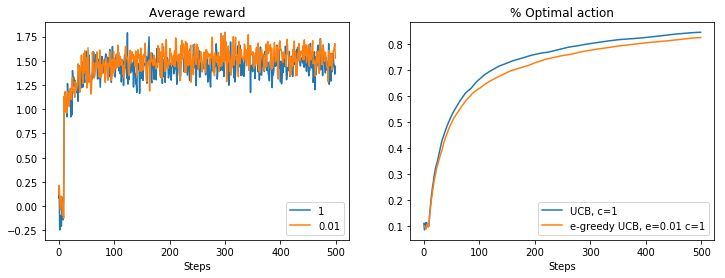

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(max_steps), avg_reward_ucb[1], label=conf_levels[1])
ax1.plot(range(max_steps), avg_reward_eps_ucb[1], label=epsilons[1])

ax2.plot(range(max_steps), avg_percent_optimal_ucb[1], 
         label='UCB, c={}'.format(conf_levels[1]))
ax2.plot(range(max_steps), avg_percent_optimal_eps_ucb[1], 
         label='e-greedy UCB, e={} c={}'.format(epsilons[1], 1))

for ax in (ax1, ax2):
    ax.set_xlabel('Steps')
    ax.legend()
ax1.set_title('Average reward')
ax2.set_title('% Optimal action')
plt.show()
print()

### Gradient bandit algorithms
Select action by "preference" (represented by softmax i.e. Boltzmann distribution with T=1, ignoring k) instead of action-value estimates.

In [186]:
def softmax(arr):
    arr -= np.max(arr)
    exp = np.exp(arr)
    return exp / np.sum(exp, axis=0)
    
def gradient_bandit(reward_function, stepsize=0.1, n_actions=10, max_steps=100):
    H = np.zeros(n_actions)
    action_set = np.arange(n_actions)
    avg_reward = 0
    actions = []
    rewards = []
    for t in range(max_steps):
        pi = softmax(H)
        action = np.random.choice(np.arange(n_actions), p=pi)
        is_not_action = action_set != action
        reward = reward_function(action)
        avg_reward += (reward - avg_reward) / (t+1)
        H[action] += stepsize * (reward - avg_reward) * (1 - pi[action])
        H[is_not_action] -= stepsize * (reward - avg_reward) * pi[is_not_action]
        
        rewards.append(reward)
        actions.append(action)
        
    optimal_action = np.argmax(reward_function.distribution.mean)
    is_optimal = np.equal(actions, optimal_action)
    percent_optimal = np.cumsum(is_optimal) / np.arange(1, max_steps+1)
    
    return pi, percent_optimal, np.array(rewards)

In [187]:
max_steps = 1000
stationary_reward = StationaryReward(n_actions)
preferences, percent_optimal, rewards = gradient_bandit(
    stationary_reward, max_steps=max_steps)

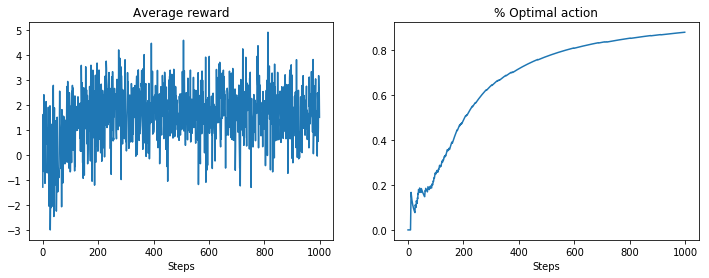

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(range(max_steps), rewards)
ax2.plot(range(max_steps), percent_optimal)
for ax in (ax1, ax2):
    ax.set_xlabel('Steps')
    ax.legend()
ax1.set_title('Average reward')
ax2.set_title('% Optimal action')
plt.show()
